<a href="https://colab.research.google.com/github/tskmr/Reliability/blob/main/lecture12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] 10.94761

[1] 0.09090909

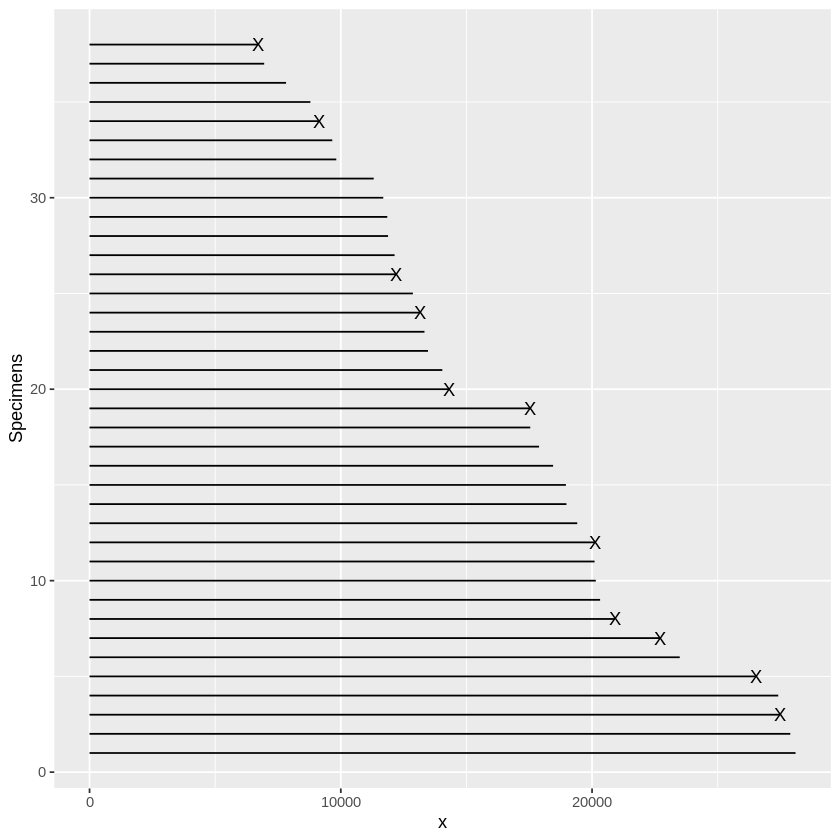

In [6]:
d = read.csv("ShockAbsorber.csv") # ショックアブソーバの故障時間データ
d$dj = as.numeric(d$Censoring.Indicator=="Failed")
d$nj = rev(seq(nrow(d)))
d %>% ggplot(aes(0, nj)) + geom_segment(aes(xend = Kilometers, yend = nj)) +geom_text(aes(x = Kilometers, label = ifelse(dj == 1, "X", ""))) +
ylab("Specimens")
sum_d = sum(d$dj)
sum_r = nrow(d) - sum_d
sum_t = sum(d$Kilometers)
hat.mu = log(sum_t/sum_d)
aVar = 1/sum_d
hat.mu
aVar

In [7]:
psev = function(z){ 1-exp(-exp(z))} # 最小極値分布の累積分布関数
dsev = function(z){ exp(z-exp(z)) } # 最小極値分布の確率密度関数
Ft = function(t, mu){ psev(log(t)-mu) } # 指数分布の累積分布関数
ft = function(t, mu){ 1/t * dsev(log(t)-mu) } # 指数分布の確率密度関数
l_i = function(x, par, n_d, n_r){ n_d * log(ft(x, par)) + n_r * log(1-Ft(x, par)) } # 1点の対数尤度.分布は指数分布を仮定
loglikelihood = function(x, n_d, n_r){# 対数尤度
function(par){ sum(l_i(x, par, n_d, n_r)) }
}
l = loglikelihood(d$Kilometers, d$dj, 1-d$dj) # 対数尤度の定義
res = optim(10, l, control = list(fnscale=-1), hessian = TRUE) # optim 関数で対数尤度を最大化
hat.mu = res$par # 最尤推定値
hat.mu
# [1] 10.94727
H_n = res$hessian # ヘッセ行列
hat.fisher.information = -H_n # 観測フィッシャー情報行列
hat.aVar = solve(hat.fisher.information) # プラグイン漸近分散
hat.aVar

Warning message in optim(10, l, control = list(fnscale = -1), hessian = TRUE):
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”


[1] 10.94727

0.09087761


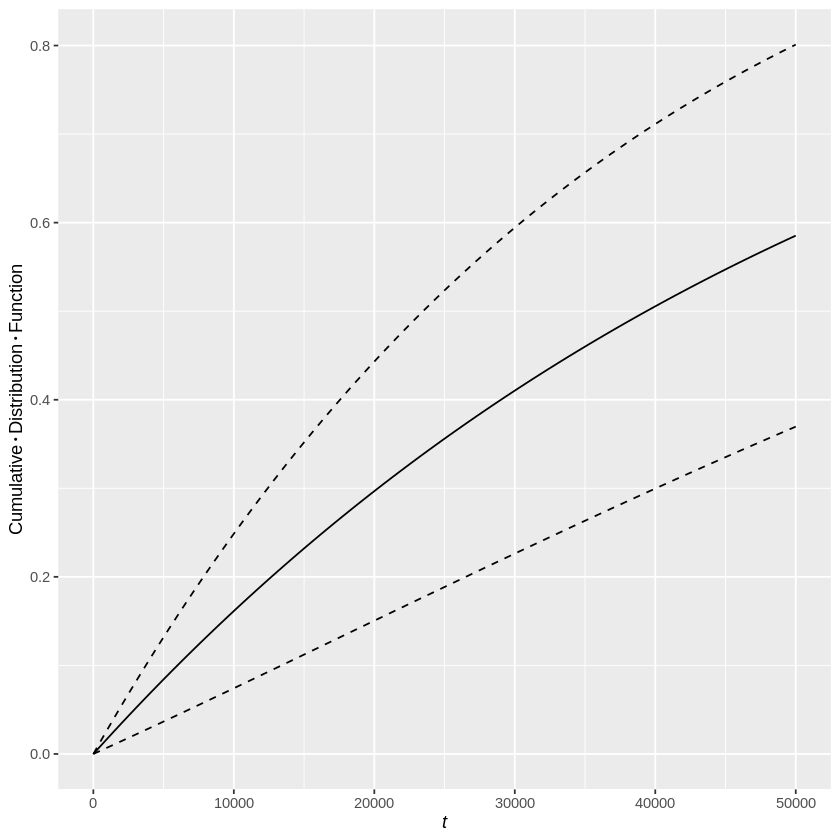

In [29]:
hat.F = function(t) {psev(log(t)-hat.mu)}
var.F = function(t){
  exp(2*(log(t)-hat.mu - exp(log(t) - hat.mu)))*aVar
}
t = seq(1, 50000, len=100)
dFT = data.frame(t,
mean=hat.F(t),
upper=hat.F(t)+qnorm(0.975)*sqrt(var.F(t)),
lower=hat.F(t)-qnorm(0.975)*sqrt(var.F(t)))
#dFT = dFT %>% mutate(upper = ifelse(upper>1, 1, upper))
plot = dFT %>%
ggplot()+geom_line(aes(t, mean))+
geom_line(aes(t, upper), linetype=2)+
geom_line(aes(t, lower), linetype=2)+
xlab(bquote(italic(t)))+ylab("Cumulative␣Distribution␣Function")
plot

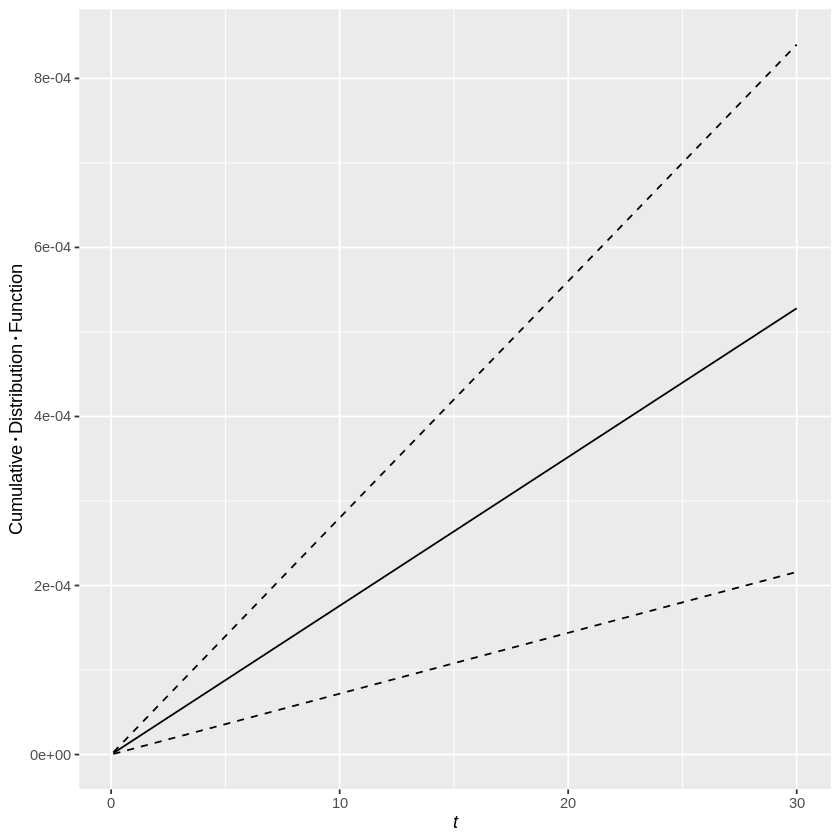

In [22]:
t = seq(0.1, 30, len=100)
dFT = data.frame(t,
mean=hat.F(t),
upper=hat.F(t)+qnorm(0.975)*sqrt(var.F(t)),
lower=hat.F(t)-qnorm(0.975)*sqrt(var.F(t)))
dFT = dFT %>% mutate(upper = ifelse(upper>1, 1, upper))
plot = dFT %>%
ggplot()+geom_line(aes(t, mean))+
geom_line(aes(t, upper), linetype=2)+
geom_line(aes(t, lower), linetype=2)+
  xlab(bquote(italic(t)))+ylab("Cumulative␣Distribution␣Function")
plot

In [17]:
ci.F = function(t){
  data.frame(t,
            mean=hat.F(t),
            upper=hat.F(t)+qnorm(0.975)*sqrt(var.F(t)),
            lower=hat.F(t)-qnorm(0.975)*sqrt(var.F(t)))
}
ci.F(20000)


t,mean,upper,lower
<dbl>,<dbl>,<dbl>,<dbl>
20000,0.2968055,0.4431311,0.15048


In [18]:
p = seq(0,1,len=100)
cdf10000 = dnorm(p, hat.F(10000), sqrt(var.F(10000)))
cdf20000 = dnorm(p, hat.F(20000), sqrt(var.F(20000)))
cdf30000 = dnorm(p, hat.F(30000), sqrt(var.F(30000)))

In [ ]:
data.frame(p, cdf10000)

In [30]:
scale.value = 3000
plot = plot +
geom_path(data=data.frame(p, cdf=cdf10000) %>% filter(cdf>0.01),
         aes(10000-cdf/max(cdf)*scale.value, p), col="skyblue")+
geom_ribbon(data=data.frame(p, cdf=cdf10000) %>% filter(cdf>0.01),
aes(xmax=10000, xmin=10000-cdf/max(cdf)*scale.value, y=p), alpha=.7, fill="skyblue")
plot = plot +
geom_path(data=data.frame(p, cdf=cdf20000) %>% filter(cdf>0.01),
         aes(20000-cdf/max(cdf)*scale.value, p), col="skyblue")+
geom_ribbon(data=data.frame(p, cdf=cdf20000) %>% filter(cdf>0.01),
aes(xmax=20000, xmin=20000-cdf/max(cdf)*scale.value, y=p), alpha=.7, fill="skyblue")
plot = plot +
  geom_path(data=data.frame(p, cdf=cdf30000) %>% filter(cdf>0.01),
aes(30000-cdf/max(cdf)*scale.value, p), col="skyblue")+
geom_ribbon(data=data.frame(p, cdf=cdf30000) %>% filter(cdf>0.01),
aes(xmax=30000, xmin=30000-cdf/max(cdf)*scale.value, y=p), alpha=.7, fill="skyblue")

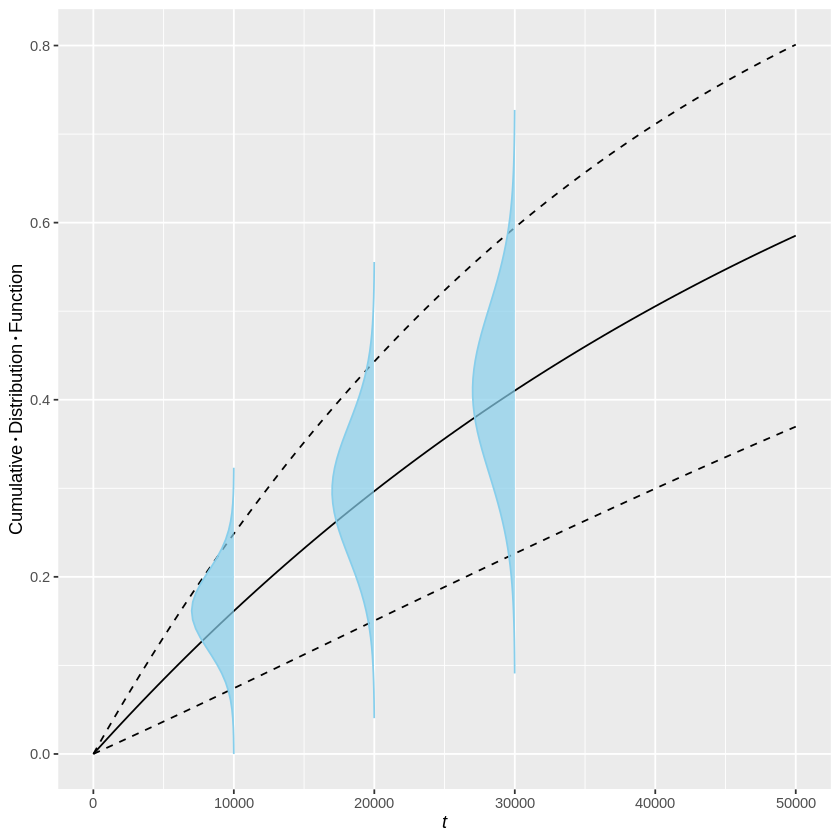

In [31]:
plot